DEBUG:cmdstanpy:input tempfile: /tmp/tmp_pt5aql_/8nqo3jjl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_pt5aql_/ssv02gsc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55961', 'data', 'file=/tmp/tmp_pt5aql_/8nqo3jjl.json', 'init=/tmp/tmp_pt5aql_/ssv02gsc.json', 'output', 'file=/tmp/tmp_pt5aql_/prophet_model2qsus17w/prophet_model-20250606132914.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:29:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:29:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Train samples: 846, Test samples: 91
MAE on test set: 90.08
RMSE on test set: 112.65


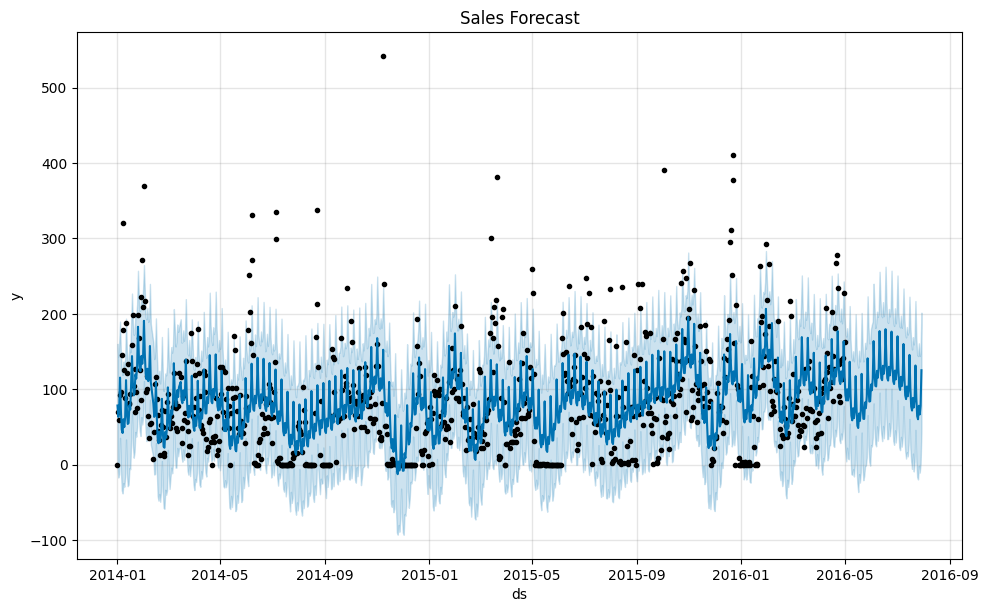

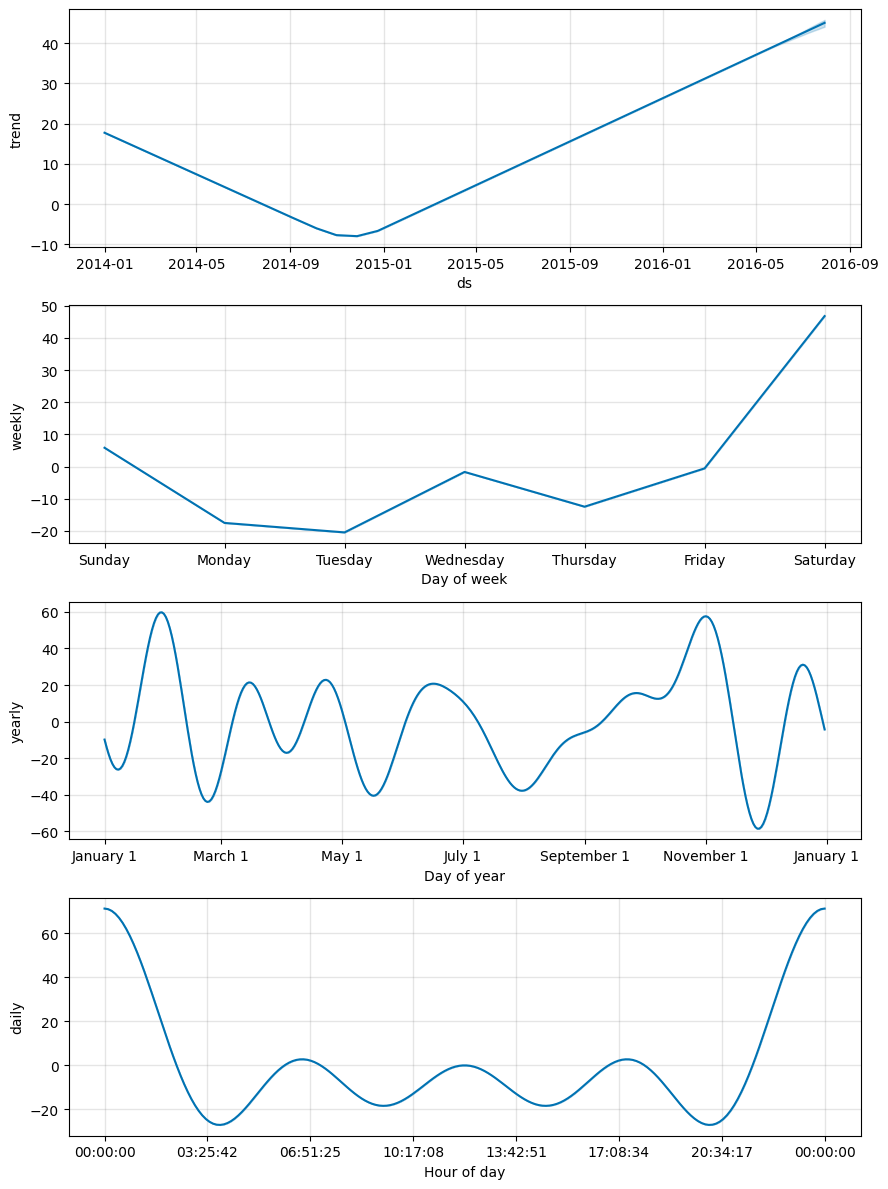

In [10]:
# ======================
# 1. Install Required Libraries
# ======================
!pip install prophet --quiet

# ======================
# 2. Import Libraries
# ======================
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# ======================
# 3. Load and Clean Data
# ======================
df = pd.read_csv('/content/mock_kaggle.csv')

# Rename columns for Prophet
df.rename(columns={'data': 'ds', 'venda': 'y'}, inplace=True)

# Convert to datetime
df['ds'] = pd.to_datetime(df['ds'])

# Drop missing values in important columns
df = df.dropna(subset=['ds', 'y'])

# Optional: Remove duplicates
df = df.drop_duplicates()

# ======================
# 4. Feature Engineering (optional, can be used for other models)
# ======================
df['month'] = df['ds'].dt.month
df['year'] = df['ds'].dt.year
df['day_of_week'] = df['ds'].dt.dayofweek

# ======================
# 5. Train-Test Split for Evaluation
# ======================
# Use last 90 days as test set
train = df[df['ds'] < (df['ds'].max() - pd.Timedelta(days=90))]
test = df[df['ds'] >= (df['ds'].max() - pd.Timedelta(days=90))]

print(f"Train samples: {len(train)}, Test samples: {len(test)}")

# ======================
# 6. Prophet Model Training
# ======================
model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
model.fit(train)

# ======================
# 7. Forecast for Test Period + Future 90 Days
# ======================
# Prepare future dataframe with test + 90 future days
future = model.make_future_dataframe(periods=90)

# Predict
forecast = model.predict(future)

# ======================
# 8. Evaluation on Test Set
# ======================
# Merge forecast with actual test values
forecast_test = forecast.set_index('ds').join(test.set_index('ds'), how='inner')

mae = mean_absolute_error(forecast_test['y'], forecast_test['yhat'])
rmse = np.sqrt(mean_squared_error(forecast_test['y'], forecast_test['yhat']))

print(f"MAE on test set: {mae:.2f}")
print(f"RMSE on test set: {rmse:.2f}")

# ======================
# 9. Save Forecast for Power BI
# ======================
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('forecast.csv', index=False)

# ======================
# 10. Plot Forecast and Components
# ======================
fig1 = model.plot(forecast)
plt.title('Sales Forecast')
fig1.savefig('forecast_plot.png')

fig2 = model.plot_components(forecast)
plt.show()
